notebook generates rebinned spectra and physical quantities, given specified integration time 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import optimize
from scipy.optimize import curve_fit

from create_arrays import create_arr
from create_spec import create_spec

In [3]:
# import arrays
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h150_subI.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h150_subI_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [4]:
t_n = tube.tarr.shape[0] - 1 # len of tube in time 
line = 1402.77
ll = np.arange(line-10,line+10,0.01)

In [5]:
k = 200
test_arr = create_arr(tube,frac,log10T,log10G,time=k)
wav,spec,error = create_spec(tube,frac,log10T,log10G,time=k)

/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays.py:58: RuntimeWarning: invalid value encountered in true_divide
  temp_fac = f_nei/f_eqi
/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays.py:119: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays.py:183: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured
/Users/WilliamHenryAshfieldIV/synth_spec/create_spec.py:103: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
/Users/WilliamHenryAshfieldIV/synth_spec/create_spec.py:163: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured


(1402, 1404)

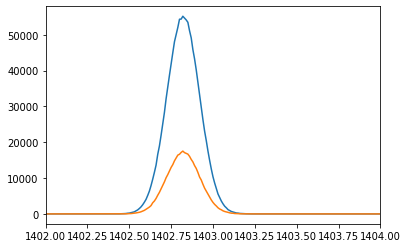

In [6]:
plt.plot(test_arr['wav'],test_arr['spec'])
plt.plot(wav,spec)
plt.xlim(1402,1404)

In [7]:
np.where(error==0)

(array([], dtype=int64),)

In [8]:
SPEC = np.zeros((t_n,len(spec)))
ERROR = np.zeros((t_n,len(error)))

shape = test_arr['i_length'] # interpolation length 
X = np.zeros((t_n,shape)) 
V = np.zeros((t_n,shape))
T = np.zeros((t_n,shape))
EMISS = np.zeros((t_n,shape))
G = np.zeros((t_n,shape))
FAC = np.zeros((t_n,shape))

for i in range(0,t_n):

    arrs = create_arr(tube,frac,log10T,log10G,time=i)
    
    SPEC[i,:] = arrs['spec']
    ERROR[i,:] = arrs['error']
    X[i,:] = arrs['x']
    V[i,:] = arrs['v']
    T[i,:] = arrs['T']   
    EMISS[i,:] = arrs['EM']
    G[i,:] = arrs['g']
    FAC[i,:] = arrs['fac']

/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays.py:119: RuntimeWarning: divide by zero encountered in true_divide
  factor = nei/eqi
/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays.py:165: RuntimeWarning: overflow encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays.py:165: RuntimeWarning: invalid value encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))


Text(0.5, 0, 'wavelength [$\\AA$]')

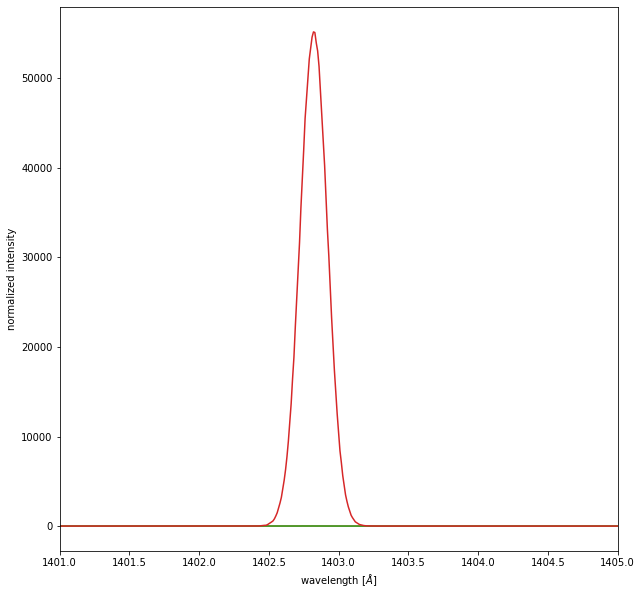

In [9]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,SPEC[5,:])
plt.plot(ll,SPEC[70,:])
plt.plot(ll,SPEC[100,:])
plt.plot(ll,SPEC[200,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

In [10]:
SPEC.shape

(500, 2000)

# Rebin our synthetic spectrum:

In [11]:
dt = 0.2
inegration = 5 # seconds (iris)
reshape = int(inegration/dt)
reshape

25

In [12]:
SPECII = SPEC.reshape(-1,reshape,2000)
SPECII.shape

ERRORII = ERROR.reshape(-1,reshape,2000)
ERRORII.shape

(20, 25, 2000)

In [13]:
spec = np.mean(SPECII,axis=1)
error = np.mean(ERRORII,axis=1)

In [14]:
nt = error.shape[0] # number of time elements after rebin.

Text(0.5, 0, 'wavelength [$\\AA$]')

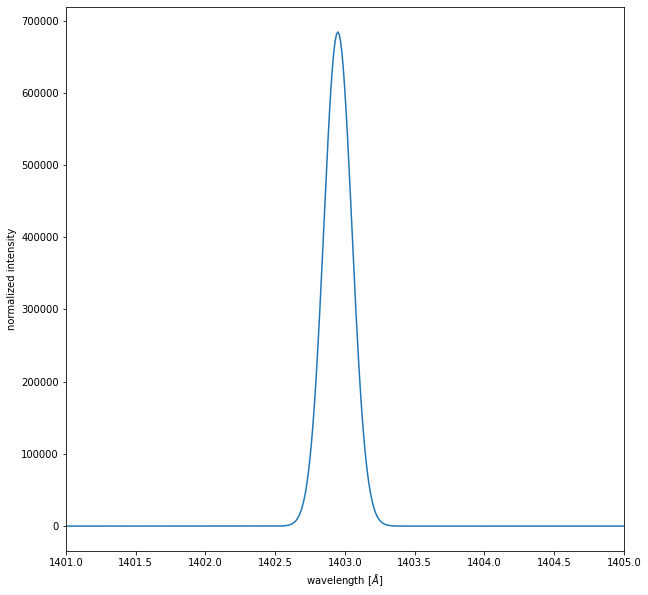

In [16]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,spec[5,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

Save new specturm array to txt file:

In [17]:
# np.savetxt('../dat/rebins/f4_t10_h20_tri.txt', spec, fmt='%d')
# np.savetxt('../dat/rebins/f4_t10_h20_tri_err.txt', error, fmt='%d')

# Animate our rebinned spectrum:

In [18]:
from matplotlib import animation, rc
from IPython.display import HTML

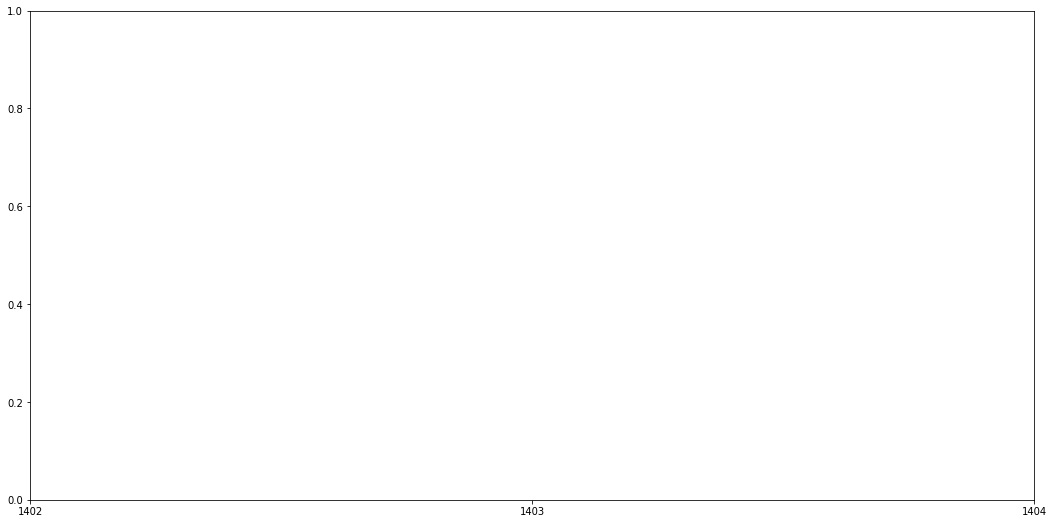

In [19]:
fig, ax = plt.subplots(figsize=(18,9))
ax.set_xlim(1402,1404)
ax.set_xticks(np.arange(1402, 1405, 1))

In [20]:
# data placeholders
wav,specs = np.zeros(0),np.zeros(0)#,np.zeros(0),np.zeros(0),np.zeros(0),np.zeros(0),np.zeros(0)

# plot placeholder/object
plot_spec, = ax.plot(wav,specs)

In [21]:
def update(i):

    global wav
    global specs
    
    wav = ll
    specs = spec[i,:]
    
    plot_spec.set_data(wav,specs)
   
    plot_spec.axes.set_ylim(0,np.max(specs)+0.05*np.max(specs))
    time = np.around(i*5, decimals=1)
    plot_spec.axes.set_ylim(0,np.max(specs)+0.05*np.max(specs))
    plot_spec.axes.set_title('time = '+str(time)+'s')
    plot_spec.axes.ticklabel_format(style='sci',axis='y',useMathText=False,scilimits=(0,2))
    
    return plot_spec

In [22]:
simulation = animation.FuncAnimation(fig, update, blit=False, frames= nt, interval=250, repeat=False)

In [23]:
HTML(simulation.to_html5_video())

In [24]:
#simulation.save(filename='sml.mp4',fps=2,dpi=300)

In [25]:
spec.shape

(20, 2000)

# Time series of synthetic spectrum:

In [30]:
time = np.arange(0,spec.shape[0]*5,5)
nt = len(time)-1

In [31]:
from fit2gauss import fit2gauss
v_r = np.zeros(nt)
v_b = np.zeros(nt)
w_r = np.zeros(nt)
w_b = np.zeros(nt)

amp = np.zeros(nt)

for i in range(0,nt):
    
    t_i = time[i]
    
    dat = spec[i,:]
    err = error[i,:]
        
    res = fit2gauss(ll,dat,err,chi_thr=100.)
    a2g = res["a2g"] # extract fit parameters
    a1g = res["a1g"]

    #calculate Doppler velocities and wavelengths
    line = 1402.77
    c = 300.
    freq = c/line*1e3

    amp[i] = a1g[0]

    if a2g[1] < a2g[4]:
        v_b[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_r[i] = (a2g[4]-line)/line*3e5
        #w_b[i] = a2g[2]*freq
        #w_r[i] = a2g[5]*freq

    else:
        v_r[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_b[i] = (a2g[4]-line)/line*3e5
        #w_r[i] = a2g[2]*freq
        #w_b[i] = a2g[5]*freq

(0, 60)

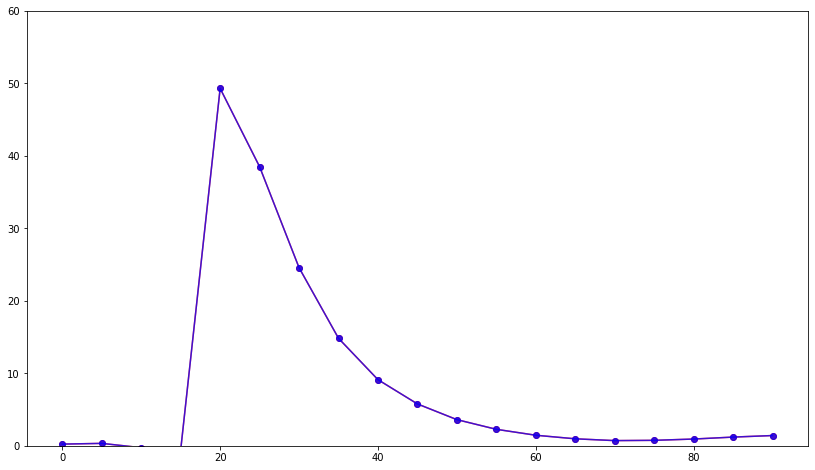

In [32]:
plt.figure(figsize=(14,8))
plt.plot(time[0:-1],v_r,'r',alpha=0.75,marker='o')
plt.plot(time[0:-1],v_b,'b',alpha=0.75,marker='o')
plt.ylim(0,60)

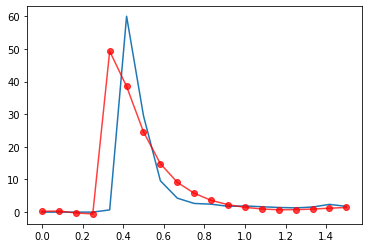

In [33]:
plt.plot(time[0:-1]/60,amp/np.max(amp)*60)
plt.plot(time[0:-1]/60,v_r,'r',alpha=0.75,marker='o')

# Fit:

In [34]:
from scipy.optimize import curve_fit

In [35]:
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [36]:
imax = np.argmax(v_r) +1

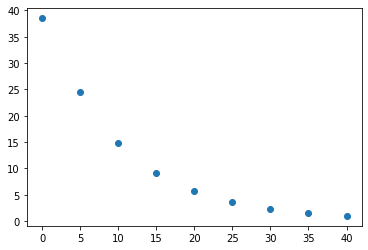

In [43]:
tt = time[imax:-6] 
tt = tt-tt[0]
vr = v_r[imax:-5]
plt.plot(tt,vr,'o')

In [44]:
a0= [55,15]
popt, pcov = curve_fit(u0_fit, tt, vr,p0=a0)

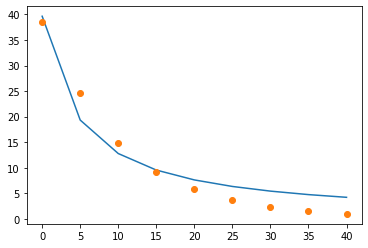

In [45]:
plt.plot(tt,u0_fit(tt,*popt))
plt.plot(tt,vr,'o')

In [46]:
popt[1]

4.756689232010273

In [47]:
H = 0.6*popt[0]*popt[1]

In [48]:
H

113.16985795544275